In [4]:
"""
Author: Moustafa Alzantot (malzantot@ucla.edu)
All rights reserved Networked and Embedded Systems Lab (NESL), UCLA.
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

'\nAuthor: Moustafa Alzantot (malzantot@ucla.edu)\nAll rights reserved Networked and Embedded Systems Lab (NESL), UCLA.\nPermission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN 

In [5]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import data_utils
import model_utils
import model

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np

INFO:tensorflow:Disabling eager execution
INFO:tensorflow:Disabling v2 tensorshape
INFO:tensorflow:Disabling resource variables
INFO:tensorflow:Disabling tensor equality
INFO:tensorflow:Disabling control flow v2


In [9]:
data = data_utils.load_training_data('ecg')

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/ecg_data/1 NSR'

## Training the model

In [7]:
# To get reasonable outputs, should use something bigger than 1000 !
num_epochs = 1000

In [ ]:
model_utils.reset_session_and_model()
with tf.Session() as sess:
    train_config = model.ModelConfig()
    test_config = model.ModelConfig()
    train_config.learning_rate = 0.003
    train_config.num_layers = 1
    train_config.batch_size = 128
    test_config.num_layers = 1
    test_config.batch_size = 1
    test_config.num_steps = 1
    loader = data_utils.DataLoader(data=data,batch_size=train_config.batch_size, num_steps=train_config.num_steps)
    train_model = model.MDNModel(train_config, True)
    test_model = model.MDNModel(test_config, False)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for idx in range(num_epochs):
        epoch_loss = train_model.train_for_epoch(sess, loader)
        print(idx, ' ', epoch_loss)
        if (idx+1) % 100 == 0:
            saver.save(sess, './models/ecg_mdnmodel.ckpt', global_step=idx)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Tensor("mdn_model/add_1:0", shape=(1280, 72), dtype=float32)
Tensor("mdn_model/strided_slice:0", shape=(1280, 24), dtype=float32)
Tensor("mdn_model/Exp:0", shape=(1280, 24), dtype=float32)
Tensor("mdn_model/y:0", shape=(128, 10, 1), dtype=float32)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to Tensor

290   -1.5276003
291   -1.526595
292   -1.5217355
293   -1.5268391
294   -1.5254116
295   -1.5270076
296   -1.5166708
297   -1.5180691
298   -1.5237727
299   -1.5181568
300   -1.5242374
301   -1.5289862
302   -1.528128
303   -1.5272272
304   -1.524831
305   -1.5213408
306   -1.5192943
307   -1.5211384
308   -1.530019
309   -1.5263447
310   -1.5278682
311   -1.5307882
312   -1.5252777
313   -1.5266764
314   -1.5286514
315   -1.5309445
316   -1.5297023
317   -1.5293146
318   -1.5215061
319   -1.5273637
320   -1.5281324
321   -1.530785
322   -1.5276033
323   -1.5312023
324   -1.5239483
325   -1.5278238
326   -1.5312405
327   -1.5315282
328   -1.5313369
329   -1.5274658
330   -1.531447
331   -1.5272026
332   -1.5241928
333   -1.530846
334   -1.5275483
335   -1.5327772
336   -1.5306683
337   -1.5268233
338   -1.526803
339   -1.5323822
340   -1.5249627
341   -1.5312594
342   -1.5224974
343   -1.5228763
344   -1.5323776
345   -1.5249143
346   -1.5284789
347   -1.5270176
348   -1.5300974
349  

## Sampling from a trained model

Tensor("mdn_model/add_1:0", shape=(1, 72), dtype=float32)
Tensor("mdn_model/strided_slice:0", shape=(1, 24), dtype=float32)
Tensor("mdn_model/Exp:0", shape=(1, 24), dtype=float32)
Tensor("mdn_model/y:0", shape=(1, 1, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from ./models/ecg_mdnmodel.ckpt-999


Text(0.5,1,'Fake data')

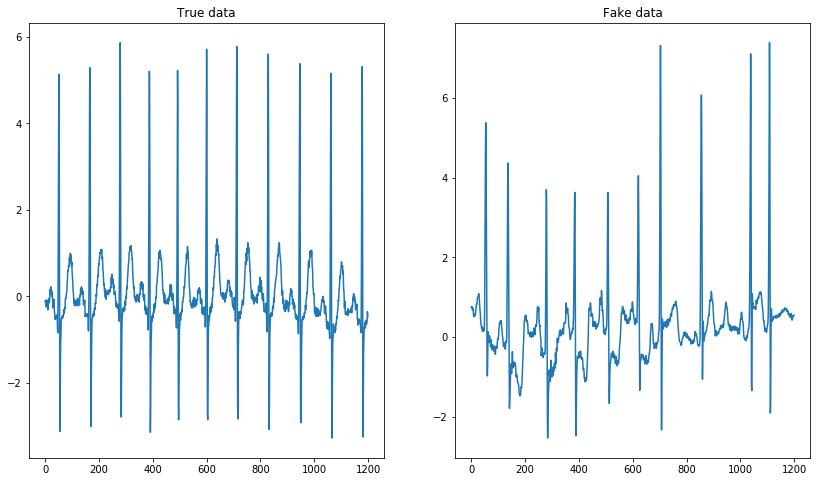

In [25]:
ckpt_path = './models/ecg_mdnmodel.ckpt-999'
seq_len = 1200
model_utils.reset_session_and_model()
true_data = data[0,:seq_len]
with tf.Session() as sess:
    test_config = model.ModelConfig()
    test_config.num_layers = 1
    test_config.batch_size = 1
    test_config.num_steps = 1
    test_model = model.MDNModel(test_config, True)
    test_model.is_training = False
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_path)
    fake_data = test_model.predict(sess, seq_len)
fig, axes = plt.subplots(1,2, figsize=((14,8)))
axes[0].plot(true_data)
axes[0].set_title('True data')
axes[1].plot(fake_data)
axes[1].set_title('Fake data')

In [26]:
## Note:
# I didn't spend time to do hyperparameter selection for the model and improve the results.
# Changing the number of Guassian mixtures, number of hidden units , number of epochs, or learning rate should improve the quality of results.
# Another useful trick would be to 'quantize' the signal into discrete set of levels and use one-hot-encoding for input processing and cross-entropy loss.
# Under such a setting, the model will be similar to the RNNLM architecture trained using maximum likelihood estimate (MLE).
# Sometimes the model above makes a mistakce and produce signal that not looking well-shaped, this is mainly due to that MLE-based models
# suffer from `exposure bias` which means at generation time the model may produce data different from those seen during training time, and since
# the model relies on its own prediction as an input for next step, the error would propagate to future time steps as well.
# Further direction of improvement would be pairing the generator model with a discriminator and train the generator by adversarial loss.

